In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import statistics
from sklearn import preprocessing
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx

In [2]:
with open('data/songkick/data_songkick_concerts_artists.csv', encoding='utf-8') as file_concerts:
    concerts_artists_df = pd.read_csv(file_concerts, index_col=0)
    
with open('data/songkick/data_songkick_concerts_light.csv', encoding='utf-8') as file_concerts:
    concerts_df = pd.read_csv(file_concerts, index_col=0)
    concerts_df.index.name = 'concert_id'
    
with open('data/songkick/data_songkick_venues.csv', encoding='utf-8') as file_venues:
    venues_df = pd.read_csv(file_venues, index_col=0)
    venues_df.index.name = 'venue_id'
    
with open('data/songkick/data_songkick_artists.csv', encoding='utf-8') as file_sk_artists:
    songkick_artists_df = pd.read_csv(file_sk_artists, index_col=0)
    
with open('data/spotify/data_spotify_artists_light.csv', encoding='utf-8') as file_artists:
    artists_df = pd.read_csv(file_artists, index_col=0)
    artists_df.index.name = 'artist_id'

with open('data/spotify/data_spotify_top_genres_v3.csv', encoding='utf-8') as file_genres:
    spotify_genres_df = pd.read_csv(file_genres, index_col=0)
    
with open('data/wikidata/data_wikidata_top_genres.csv', encoding='utf-8') as file_genres:
    wikidata_genres_df = pd.read_csv(file_genres, index_col=0)
    
with open('data/wikidata/data_wikidata_unique_top_genres_manual.csv', encoding='utf-8') as file_genres:
    wikidata_unique_genres_df = pd.read_csv(file_genres, index_col=0)
    
with open('data/wikidata/data_wikidata_top_genres_list_manual.csv', encoding='utf-8') as file_genres:
    wikidata_manual_top_genres_df = pd.read_csv(file_genres, index_col=0)

## Songkick stats

In [67]:
full_songkick_df = concerts_artists_df.merge(concerts_df[['venue_id', 'startDate']], left_on='concert_id', right_index=True)
full_songkick_df = full_songkick_df.merge(venues_df[['locality', 'longitude', 'latitude']], left_on='venue_id', right_index=True)
full_songkick_df.loc[full_songkick_df['concert_id'] == '/concerts/36259569']

,concert_id,artist_id,venue_id,startDate,locality,longitude,latitude
32066,/concerts/36259569,/artists/8755459-use-fr,/venues/2837343,2019-03-28,Lausanne,6.63141,46.52012
32067,/concerts/36259569,/artists/482962-frustration,/venues/2837343,2019-03-28,Lausanne,6.63141,46.52012


In [36]:
full_songkick_df.count()

concert_id    117760
artist_id     117760
venue_id      117760
startDate     117760
locality      117760
longitude     109292
latitude      109292
dtype: int64

In [39]:
date_filter = full_songkick_df[(full_songkick_df['startDate'] > '2010-01-01') & (full_songkick_df['startDate'] < '2020-01-01')].index
filtered_songkick_df = full_songkick_df.iloc[date_filter]
filtered_songkick_df

,concert_id,artist_id,venue_id,startDate,locality,longitude,latitude
9,/festivals/3250138,/artists/10069604-flavio-stonex,/venues/1943879,2019-10-12,Mels,9.42400,47.04380
10,/concerts/32335899,/artists/11032-jazz-connection,/venues/1943879,2018-08-11,Mels,9.42400,47.04380
11,/concerts/32335884,/artists/11032-jazz-connection,/venues/1943879,2018-08-10,Mels,9.42400,47.04380
12,/concerts/13429724,/artists/2865626-james-lann,/venues/1943879,2012-08-10,Mels,9.42400,47.04380
4,/festivals/3250141,/artists/10069604-flavio-stonex,/venues/2077709,2020-10-17,Mels,NaN,NaN
...,...,...,...,...,...,...,...
117755,/concerts/14836234,/artists/456971-funeral-for-a-friend,/venues/2148724,2013-04-07,Zürich,8.49986,47.38732
117756,/concerts/14836234,/artists/4578008-tidal-sleep,/venues/2148724,2013-04-07,Zürich,8.49986,47.38732
117757,/concerts/14836234,/artists/424864-silverstein,/venues/2148724,2013-04-07,Zürich,8.49986,47.38732
117758,/concerts/16089124,/artists/6316464-vatsgoed,/venues/2148724,2013-04-05,Zürich,8.49986,47.38732


In [41]:
filtered_songkick_df.count()

concert_id    97619
artist_id     97619
venue_id      97619
startDate     97619
locality      97619
longitude     91099
latitude      91099
dtype: int64

## Wikidata stats

In [65]:
wikidata_genres_df.nunique()

genre_id              4579
genre_name            4574
genre_name_edited     4570
top_genre_id          1403
top_genre_name        1403
unique_top_genre         2
everynoise_id         1385
everynoise_name       1385
discogs_genre_name      14
discogs_style_name     555
dtype: int64

In [55]:
wikidata_manual_top_genres_df.count()

top_genre           50
manual_top_genre    27
dtype: int64

In [62]:
artists_matched_df = artists_df.loc[pd.notna(artists_df['spotify_id'])]
spotify_popularity = artists_matched_df['spotify_popularity']
spotify_followers = artists_matched_df['spotify_followers']
spotify_listeners = artists_matched_df['spotify_listeners']
artists_matched_stats_df = artists_matched_df[['spotify_popularity', 'spotify_followers', 'spotify_listeners']]
artists_matched_stats_df

,spotify_popularity,spotify_followers,spotify_listeners
artist_id,,,
/artists/3684861-chk-chk-chk,46.0,133869.0,341800.0
/artists/694091-kadebostan,10.0,1342.0,2000.0
/artists/7433784-pyramids-jazz,26.0,1132.0,25100.0
/artists/8375378-agcrew,29.0,17632.0,28100.0
/artists/44425-smoove,0.0,1.0,28100.0
...,...,...,...
/artists/9915344-stas-mikhailov,2.0,52.0,226.0
/artists/4301-and-you-will-know-us-by-the-trail-of-dead,39.0,63953.0,96600.0
/artists/1099500-euuroshima,36.0,14555.0,90100.0


In [4]:
# artists stats

nbr_songkick_artists = len(artists_df)
nbr_spotify_artists = len(artists_matched_df)
nbr_songkick_artists_unmatched = nbr_songkick_artists - nbr_spotify_artists

unique_spotify_id = artists_df['spotify_id'].value_counts()
idx_list = list()
"""
for idx in list(unique_spotify_id[unique_spotify_id > 1].index):
    idx_list.extend(list(artists_df.loc[artists_df['spotify_id'] == idx].index))
"""
nbr_duplicate_matches = len(idx_list)

mean_popularity = round(spotify_popularity.mean(), 2)
median_popularity = statistics.median(spotify_popularity)
mean_followers = round(spotify_followers.mean(), 2)
median_followers = statistics.median(spotify_followers)
mean_listeners = round(spotify_listeners.mean(), 2)
median_listeners = statistics.median(spotify_listeners)

artists_stats = {
    'nbr_songkick_artists': nbr_songkick_artists,
    'nbr_spotify_artists': nbr_spotify_artists,
    'nbr_songkick_artists_unmatched': nbr_songkick_artists_unmatched,
    'nbr_duplicate_matches': nbr_duplicate_matches,
    'mean_popularity': mean_popularity,
    'median_popularity': median_popularity,
    'mean_followers': mean_followers,
    'median_followers': median_followers,
    'mean_listeners': mean_listeners,
    'median_listeners': median_listeners,
}
artists_stats

{'nbr_songkick_artists': 32231,
 'nbr_spotify_artists': 28537,
 'nbr_songkick_artists_unmatched': 3694,
 'nbr_duplicate_matches': 0,
 'mean_popularity': 22.91,
 'median_popularity': 19.0,
 'mean_followers': 181024.72,
 'median_followers': 2385.0,
 'mean_listeners': 484408.12,
 'median_listeners': 7000.0}

In [128]:
standardizer = preprocessing.StandardScaler()
minmax = preprocessing.MinMaxScaler()
normalizer = preprocessing.Normalizer()

t = np.asarray(spotify_popularity).reshape(-1,1)
std_popularity = standardizer.fit_transform(t)

In [129]:
stats_array = artists_matched_stats_df.values
stats_std = standardizer.fit_transform(stats_array.T)
stats_norm = normalizer.fit_transform(stats_array.T)
stats_norm

array([[8.78358831e-03, 1.90947572e-03, 4.96463687e-03, ...,
        6.87411259e-03, 2.86421358e-03, 4.96463687e-03],
       [5.25723450e-04, 5.27023336e-06, 4.44553216e-06, ...,
        5.71596472e-05, 2.62961867e-05, 6.26144565e-05],
       [7.69671717e-04, 4.50363790e-06, 5.65206556e-05, ...,
        2.02888887e-04, 1.14842766e-05, 4.18838325e-05]])

In [54]:
X = np.asarray([1, -1, 2])
print(X)
x1 = np.random.randint(0, 100, 10)
print(x1)
normalizer.transform

[ 1 -1  2]
[ 9 54 34 95 20 76 79 56 19 20]


In [135]:
stats_array.T

array([[4.60000e+01, 1.00000e+01, 2.60000e+01, ..., 3.60000e+01,
        1.50000e+01, 2.60000e+01],
       [1.33869e+05, 1.34200e+03, 1.13200e+03, ..., 1.45550e+04,
        6.69600e+03, 1.59440e+04],
       [3.41800e+05, 2.00000e+03, 2.51000e+04, ..., 9.01000e+04,
        5.10000e+03, 1.86000e+04]])

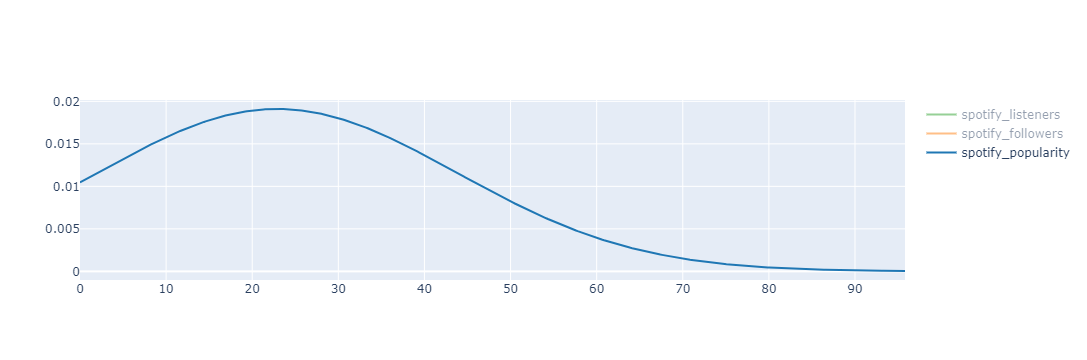

In [136]:
distri_data = [x for x in stats_array.T]
distri_label = [label for label in artists_matched_stats_df.columns]

fig = ff.create_distplot(
    distri_data,
    distri_label,
    curve_type='normal',  # override default 'kde'
    show_hist=False,
    show_rug=False,
)
fig.show()

In [7]:
genres_df

,spotify_genre,top_genre
0,21st century classical,art music
1,5th wave emo,experimental music
2,5th wave emo,world music
3,5th wave emo,hip hop music
4,5th wave emo,electronic music
...,...,...
6049,zouk riddim,electronic music
6050,zouk riddim,dance music
6051,zouk riddim,instrumental music
6052,zurich indie,world music


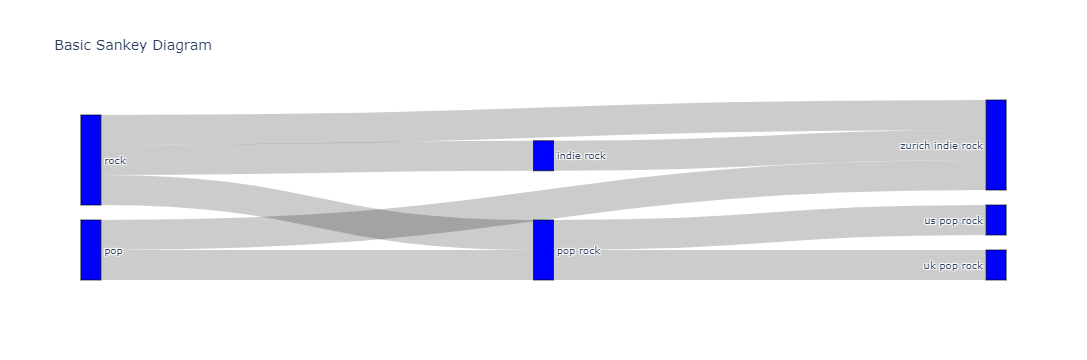

In [182]:
import plotly.graph_objects as go

label = [
    'rock',
    'pop',
    'indie rock',
    'pop rock',
    'zurich indie rock',
    'us pop rock',
    'uk pop rock',
]

source = [0, 0, 1, 2, 3, 3, 1, 0]
target = [2, 3, 3, 4, 5, 6, 4, 4]

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = label,
      color = "blue"
    ),
    link = dict(
      source = source,
      target = target,
      value = [1, 1, 1, 1, 1, 1, 1, 1],
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

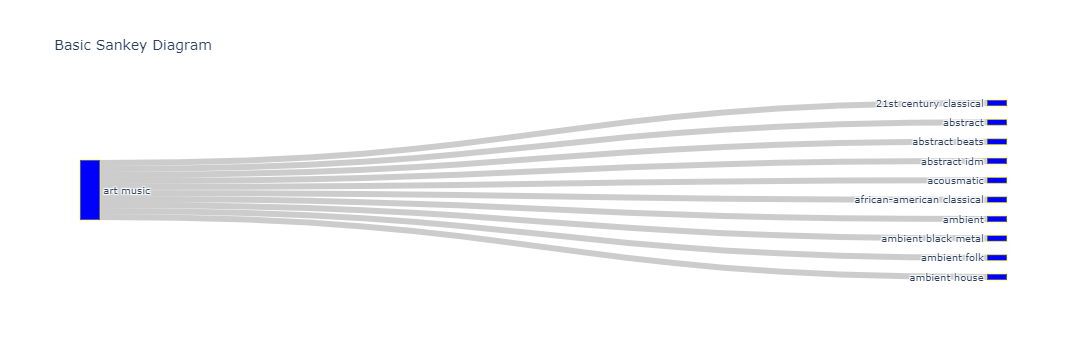

In [194]:
genres_dict = dict()
source = list()
target = list()
label = list()

top_genres = genres_df['top_genre'].unique()
for parent_genre in top_genres[:1]:
    parent_genre_df = genres_df.loc[genres_df['top_genre'] == parent_genre]
    sub_genres = parent_genre_df['spotify_genre'].unique()[:10]
    genres_dict[parent_genre] = list(sub_genres)
    for sub_genre in sub_genres:
        genres_dict[sub_genre] = list()

label = list(genres_dict.keys())
value = [1 for x in range(len(label))]

for parent_genre, sub_genres in genres_dict.items():
    parent_index = label.index(parent_genre)
    for sub_genre in sub_genres:
        sub_index = label.index(sub_genre)
        source.append(parent_index)
        target.append(sub_index)
        
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "yellow", width = 0.5),
      label = label,
      color = "blue"
    ),
    link = dict(
      source = source,
      target = target,
      value = value,
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

---
---

In [80]:
artists_multiple_matches_df = artists_df.loc[idx_list].sort_values(by=['spotify_name'])
artists_multiple_matches_df.to_csv('data/spotify/data_spotify_artists_multiple_matches.csv', encoding='utf-8')
artists_multiple_matches_df

,artist_name,spotify_name,spotify_id,spotify_popularity,spotify_followers,spotify_listeners
artist_id,,,,,,
/artists/10119580-22deg-halo,22° Halo,22º Halo,6p355yiyJc67iSNeWLM8WH,11.0,1067.0,1500.0
/artists/9804639-22-halo,22 Halo,22º Halo,6p355yiyJc67iSNeWLM8WH,11.0,1067.0,1500.0
/artists/7309389-a-crashed-blackbird-rosehip,A Crashed Blackbird Rosehip,A Crashed Blackbird Called Rosehip,1NKizqgwDCXtUbMHeqA2Tv,6.0,88.0,635.0
/artists/6506249-a-crashed-blackbird-called-rosehip,A Crashed Blackbird Called Rosehip,A Crashed Blackbird Called Rosehip,1NKizqgwDCXtUbMHeqA2Tv,6.0,88.0,635.0
/artists/5990259-aspell,A-Spell,A.Spell,4zkmCFtAa1ETWHoZ2sNGvO,0.0,25.0,9.0
...,...,...,...,...,...,...
/artists/531180-za,Za!,Zaz,1mbgj8ERPs8lWi7t5cYrdy,65.0,1195585.0,2100000.0
/artists/25827-zippo,Zippo,Zippo,7Int2nVSzSBL8UDty3jGAR,23.0,1363.0,1300.0
/artists/7284179-zippo-italy,Zippo,Zippo,7Int2nVSzSBL8UDty3jGAR,23.0,1363.0,1300.0
